<h2 align="center">Predict Employee Churn with Decision Trees and Random Forests</h2>


In [16]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import pandas_profiling
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [17]:
plt.rcParams['figure.figsize'] = (12,8)

### Exploratory Data Analysis
---

In [18]:
# import dataset
data = pd.read_csv('employee_data.csv')

data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [19]:
data.profile_report(title = "data report") # finishes executing the report

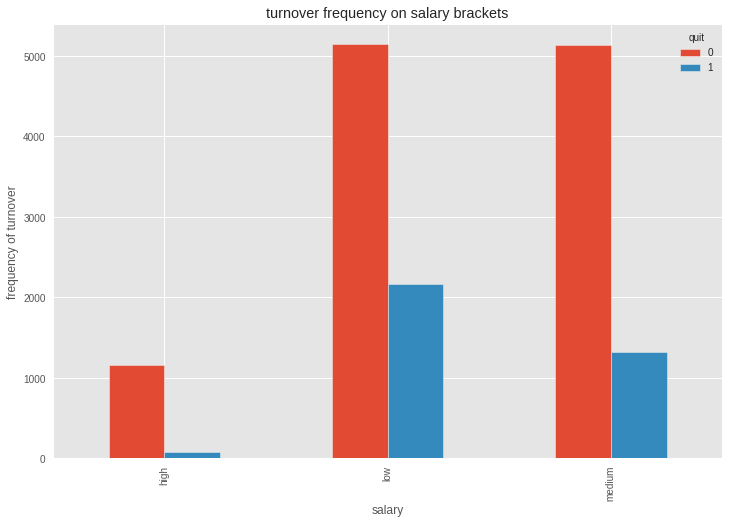

In [20]:
# visualize the data
# how quit depends on salary, since salary is a categorical variable, so lets create a bar plot
pd.crosstab(data.salary, data.quit).plot(kind='bar')
plt.title("turnover frequency on salary brackets")
plt.xlabel('salary')
plt.ylabel('frequency of turnover')
plt.show()

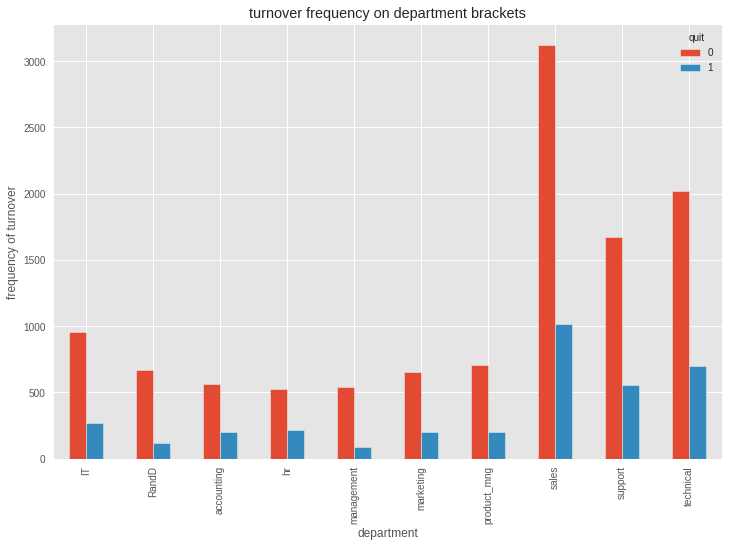

In [21]:
# visualize the data
# how quit depends on department, since department is a categorical variable, so lets create a bar plot
pd.crosstab(data.department, data.quit).plot(kind='bar')
plt.title("turnover frequency on department brackets")
plt.xlabel('department')
plt.ylabel('frequency of turnover')
plt.show()

### Encode Categorical Features
---

In [22]:
# encode the categorical variables into dummy or hot encoded variables
# for instance, department variable has 10 categories, so lets convert each department into a
# dummy variable
categorical_variables = ['department', 'salary']

for var in categorical_variables:
    categorical_list = pd.get_dummies(data[var], prefix = var)
    data = data.join(categorical_list)

In [23]:
data.head() # now 2 new columns will be added

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0


In [24]:
# drop the list of columns which have been hot encoded above
data.drop(columns = ['department', 'salary'], axis = 1, inplace = True) # axis = 1, since we are dropping the columns


In [25]:
# visualize the class balance, if the dataset is class balanced or not


### Visualize Class Imbalances
---

In [26]:
from yellowbrick.target import ClassBalance # machine learning diagnostic library
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

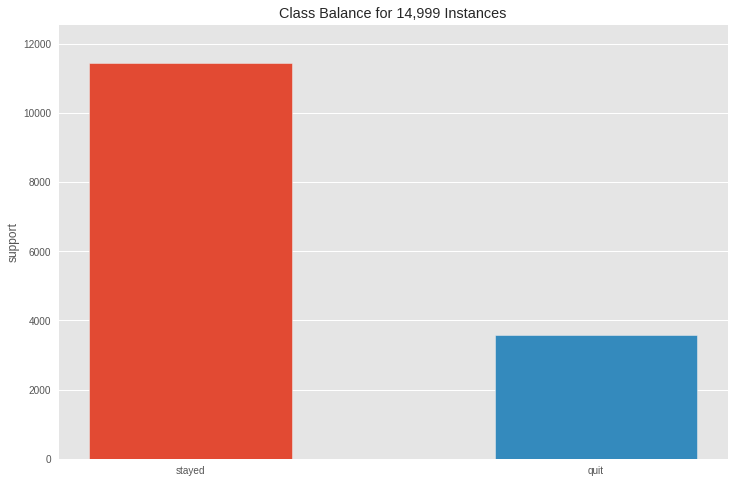

In [27]:
# SHOW THE TARGET VARIABLES IN 1 AND 0 IN THE FORM OF STAYED OR QUIT
visualizer = ClassBalance(labels=['stayed', 'quit']).fit(data.quit) # fit(target_variable)
visualizer.show()

### Create Training and Test Sets
---

In [28]:
x = data.loc[:, data.columns!='quit']
y = data.quit


In [29]:
from sklearn.model_selection import train_test_split
# since the dataset is unbalanced, lets stratify the target variables

x_train , x_test, y_train, y_test = train_test_split(x, y, random_state = 0, test_size = 0.2, stratify = y)

### Build an Interactive Decision Tree Classifier
---

Supervised learning:
- The inputs are random variables $X = X_1, ..., X_p$;
- The output is a random variable $Y.$

- Data is a finite set $$\mathbb{L}=\{(x_i,y_i)|i=0, ..., N-1\}$$
where $x_i \in X = X_1 \times ... \times X_p$ and $y_i \in y$ are randomly drawn from $P_{X,Y}.$

E.g., $(x_i,y_i)=((\text{salary = low, department = sales, ...}),\text{quit = 1})$

- The goal is to find a model $\varphi_\mathbb{L}: X \mapsto y$ minimizing $$\text{Err}(\varphi_\mathbb{L}) = \mathbb{E}_{X,Y}\{L(Y, \varphi_\mathbb{L}(X))\}.$$

About:

 - Decision trees are non-parametric models which can model arbitrarily complex relations between inputs and outputs, without any a priori assumption

- Decision trees handle numeric and categorical variables

- They implement feature selection, making them robust to noisy features (to an extent)

- Robust to outliers or errors in labels

- Easily interpretable by even non-ML practioners.

#### Decision trees: partitioning the feature space:

![partition](assets/images/partition-feature-space.png)

- Decision trees generally have low bias but have high variance.
- We will solve the high variance problem in Task 8.

In [30]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [31]:
@interact
def plot_tree(crit=['gini', 'entropy'] ,
              split=['best', 'split'],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=1,max=5,value=2, continuous_update=False), # number of samples to split an internal node
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)): # min number of samples, required for internal leaf node


    estimator = DecisionTreeClassifier(random_state=0,
                                  criterion = crit,
                                  splitter= split,
                                  max_depth = depth,
                                  min_samples_split = min_split,
                                  min_samples_leaf = min_leaf)
    estimator.fit(x_train, y_train)


    print('decision tree training accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(x_train))))
    print('decision tree test accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(x_test))))

    graph = Source(tree.export_graphviz(estimator, out_file=None,
                                        feature_names=x_train.columns,
                                        class_names = ['stayed', 'quit'],
                                        filled = True))
    display(Image(data=graph.pipe(format='png')))
    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Build an Interactive Random Forest Classifier
---

Although randomization increases bias, it is possible to get a reduction in variance of the ensemble. Random forests are one of the most robust machine learning algorithms for a variety of problems.

- Randomization and averaging lead to a reduction in variance and improve accuracy
- The implementations are parallelizable
- Memory consumption and training time can be reduced by bootstrapping
- Sampling features and not solely sampling examples is crucial to improving accuracy

In [ ]:
@interact
def plot_tree_rf(crit=['gini', 'entropy'],
                 bootstrap=['True', 'False'],
                 depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):


    estimator = RandomForestClassifier(random_state=1,
                                      criterion=crit,
                                      bootstrap=bootstrap,
                                      n_estimators=forests,
                                      max_depth=depth,
                                      min_samples_split=min_split,
                                      min_samples_leaf=min_leaf,
                                      n_jobs=-1,
                                      verbose=False) # no debug information

    estimator.fit(x_train, y_train)
    print('random tree training accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(x_train))))
    print('random tree test accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(x_test))))

    num_tree = estimator.estimators_[0]

    print('Visualizing tree no: ', 0)
    graph = Source(tree.export_graphviz(num_tree,
                                        out_file=None,
                                        feature_names=x_train.columns,
                                        class_names = ['stayed', 'quit'],
                                        filled = True))
    display(Image(data=graph.pipe(format='png')))
    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Feature Importance and Evaluation Metrics
---

In [33]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

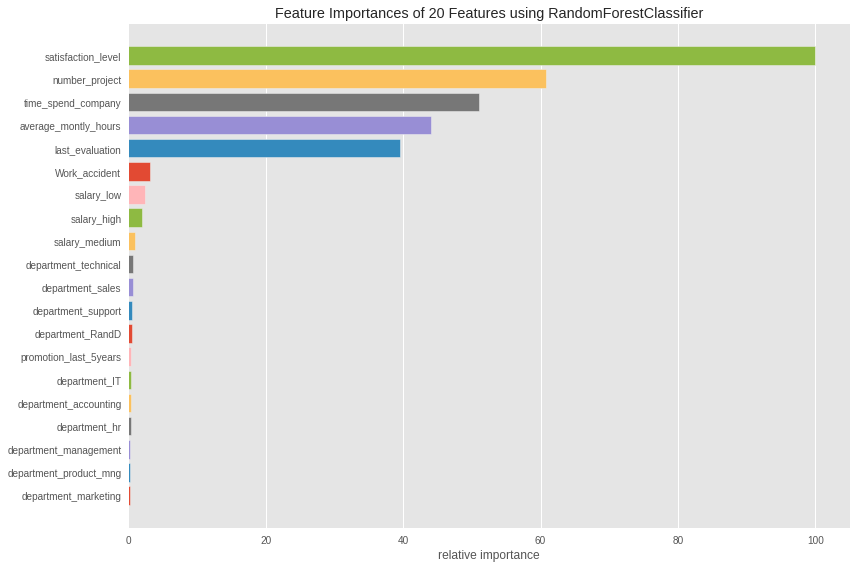

In [34]:
# visualize how random forest gives importance to which feature
rf = RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=False,
            warm_start=False)
viz = FeatureImportances(rf)
viz.fit(x_train, y_train)
viz.show()

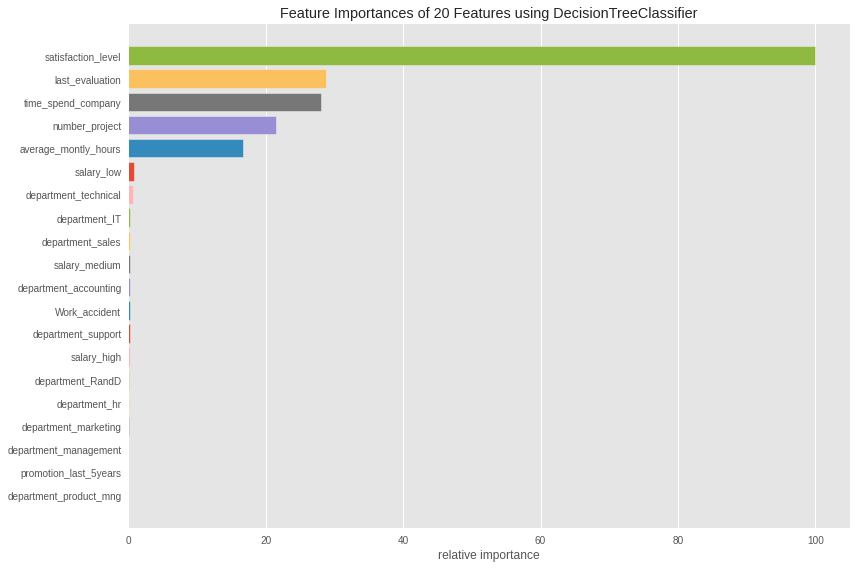

In [35]:
dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
viz = FeatureImportances(dt)
viz.fit(x_train, y_train)
viz.show()

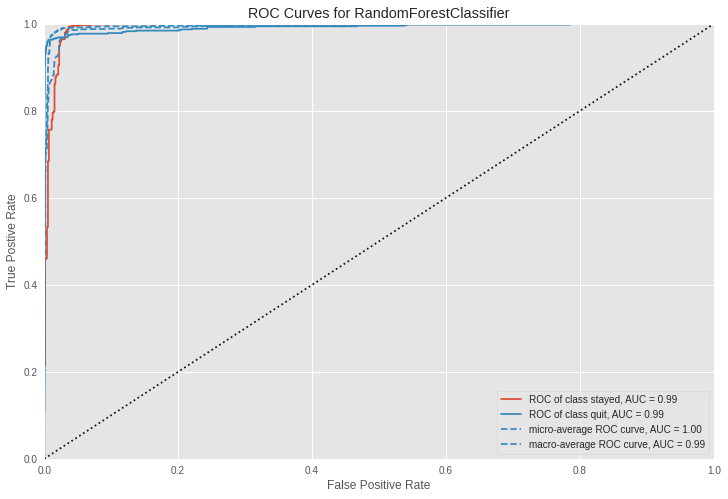

In [36]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(rf, classes = ['stayed', 'quit'])

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.poof()

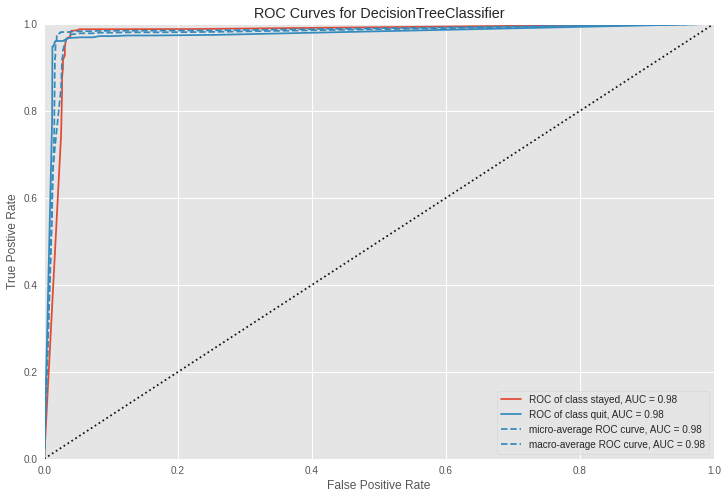

In [37]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(dt, classes = ['stayed', 'quit'])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.poof()